# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection** 

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
--- 

## Import Packages

In [1]:
#importing some useful packages
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from lesson_functions import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time

## Data Exploration

### Read in Image files, split it to Trainning and Test set, Image visualization

There are 8792 car images, split 7032 for training and 1760 for test
There are 8968 non_car images, split 7174 for training and 1794 for test


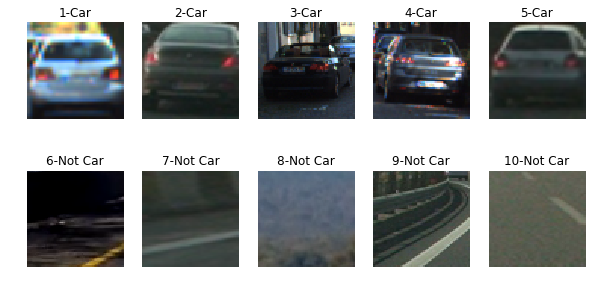

In [2]:
## Manually split files in each folder with 0.8/0.2 Train/Test as there are time sequence samples in GTI imaages
def file_split(path, rate=0.8):
    file = glob.glob(path + '/*.png')
    cut = int(rate*len(file))
    #print (cut)
    file1 = file[:cut]
    file2 = file[cut:]
    
    #print (file1[len(file1)-1], file2[0])
    return file1, file2

car_train_file, car_test_file = [], []
not_car_train_file, not_car_test_file = [], []

for dir in glob.glob('data/vehicles/*'):
    file1, file2 = file_split(dir)
    car_train_file.extend(file1)
    car_test_file.extend(file2)

for dir in glob.glob('data/non-vehicles/*'):
    file1, file2 = file_split(dir)
    not_car_train_file.extend(file1)
    not_car_test_file.extend(file2)

print ('There are {} car images, split {} for training and {} for test'.
       format((len(car_train_file)+len(car_test_file)),len(car_train_file), len(car_test_file)))
print ('There are {} non_car images, split {} for training and {} for test'.
       format((len(not_car_train_file)+len(not_car_test_file)), len(not_car_train_file), len(not_car_test_file)))

# Sample image visualzation
fig, axs = plt.subplots(2, 5, figsize=(10,5))
axs = axs.ravel()
for i in range(5):
    #plt.subplot(1, 5, i+1)
    image1 = mpimg.imread(car_train_file[np.random.randint(0, len(car_train_file))])
    axs[i].axis('off')
    axs[i].set_title(str(i+1)+'-Car')
    axs[i].imshow(image1) 
for i in range(5,10):
    image2 = mpimg.imread(not_car_train_file[np.random.randint(0, len(not_car_train_file))])
    axs[i].axis('off')
    axs[i].set_title(str(i+1)+'-Not Car')
    axs[i].imshow(image2)

plt.savefig('output_images/car_noncar.png')
plt.show()

## HOG Classify and Trainning with Linear SVM

### HOG Feature Visalize with Image Samples

C:\Users\Kaiyu\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


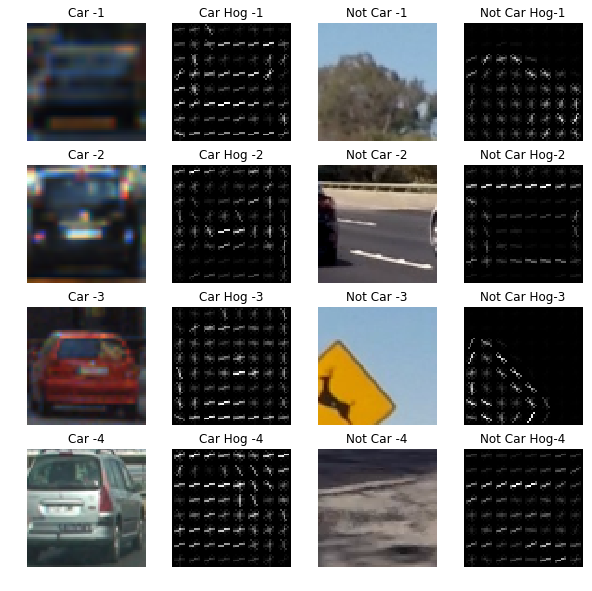

In [3]:
# Visualize HOG examples
plt.figure(figsize=(10,10))
for i in range(4):
    car_img = mpimg.imread(car_train_file[np.random.randint(0, len(car_train_file))])
    car_hog = get_hog_features(car_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)[1]
    noncar_img = mpimg.imread(not_car_train_file[np.random.randint(0, len(not_car_train_file))])
    noncar_hog = get_hog_features(noncar_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)[1]
    plt.subplot(4,4,4*i+1)
    plt.axis('off')
    plt.title('Car -'+ str(i+1))
    plt.imshow(car_img)
    plt.subplot(4,4,4*i+2)
    plt.axis('off')
    plt.title('Car Hog -'+ str(i+1))
    plt.imshow(car_hog, cmap='gray')
    plt.subplot(4,4,4*i+3)
    plt.axis('off')
    plt.title('Not Car -'+ str(i+1))
    plt.imshow(noncar_img)
    plt.subplot(4,4,4*i+4)
    plt.axis('off')
    plt.title('Not Car Hog-'+ str(i+1))
    plt.imshow(noncar_hog, cmap='gray')

plt.savefig('output_images/car_noncar_hog.png')
plt.show()


### Extract Featuers with Spatial, Color Hist, and HOG

In [4]:
# Extract Feathuers

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
car_train_f = extract_features(car_train_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

car_test_f = extract_features(car_test_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

noncar_train_f = extract_features(not_car_train_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

noncar_test_f = extract_features(not_car_test_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2=time.time()
print (round(t2-t, 2), 'Seconds to extract features')

C:\Users\Kaiyu\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


81.55 Seconds to extract features


### Normalize data and shuffle, Train with linear SVM

In [5]:
# Create an array stack of feature vectors
#normalize combineded data set and sperate them again for Trainning and test
X= np.vstack((car_train_f, noncar_train_f, car_test_f, noncar_test_f)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

l1 = len(car_train_f)
l2 = len(noncar_train_f)
l3 = len(car_test_f)
l4 = len(noncar_test_f)

X_train = np.vstack((scaled_X[:l1], scaled_X[l1:(l1+l2)]))
y_train = np.hstack((np.ones(l1), np.zeros(l2)))
X_test = np.vstack((scaled_X[(l1+l2):(l1+l2+l3)], scaled_X[(l1+l2+l3):]))
y_test = np.hstack((np.ones(l3), np.zeros(l4)))

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [6]:
# Train classifier with Linear SVC and check prediction
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
17.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9842
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.
  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.
  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.]
For these 100 labels:  [ 1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.
  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.
  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  1.  1.  1.  1.

## Detect Car with Classifier

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    car_windows = []
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        #print ("shape1:", imshape)
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        #print ("shape2:", ctrans_tosearch.shape)
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return car_windows

C:\Users\Kaiyu\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


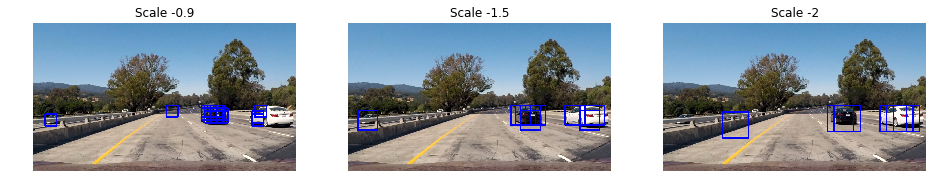

In [8]:
# Visualize Find Car function on test image, using scale 1, 1.5 and 2
image = mpimg.imread("test_images/test1.jpg")
#image = mpimg.imread("frame01sec.jpg")
draw_image = np.copy(image)
ystart = 400
ystop = 656
scales = [0.9, 1.5, 2]
hot_windows = []

plt.figure(figsize=(16,5))
for i, scale in enumerate(scales):
    car_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins)
    #print(len(car_windows))
    #print('car window scale', scale, car_windows)
    hot_windows.extend(car_windows)
    #print('hot window', hot_windows)
    
    plt.subplot(1,3,i+1)
    plt.title('Scale -'+ str(scale))
    scale_img = draw_boxes(draw_image, car_windows, color=(0, 0, 255), thick=6)
    plt.axis('off')
    plt.imshow(scale_img)

plt.savefig('output_images/find_car.png')
plt.show()

### Heatmap to resolve multiple detections and false positives

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

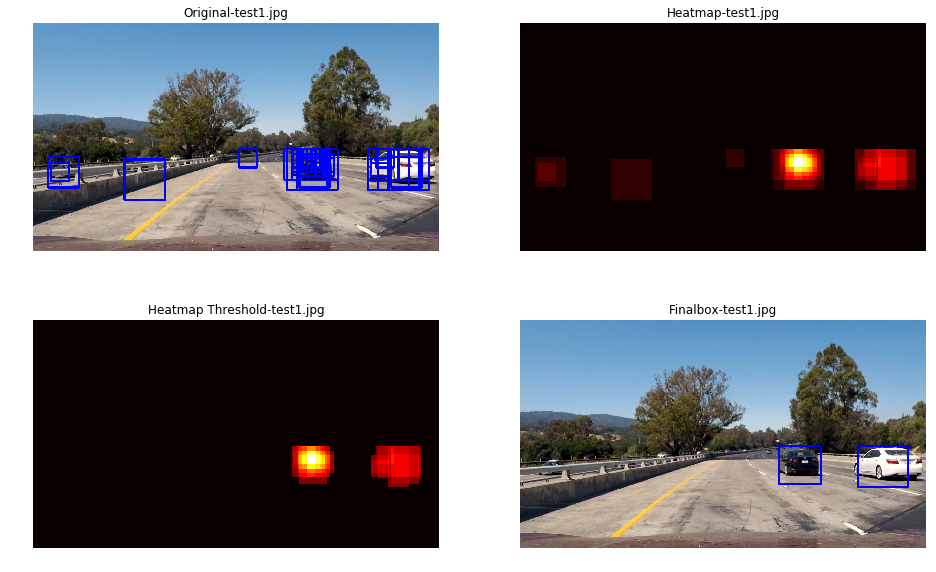

In [10]:
# Visualize Heatmap on test images
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
heatmap_img = np.zeros_like(image[:,:,0])
heatmap_img = add_heat(heatmap_img, hot_windows)

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.title('Original-test1.jpg')
plt.axis('off')
plt.imshow(window_img)

plt.subplot(2,2,2)
plt.title('Heatmap-test1.jpg')
plt.axis('off')
plt.imshow(heatmap_img, cmap='hot')

plt.subplot(2,2,3)
heatmap_threshold = apply_threshold(heatmap_img, 2)
plt.title('Heatmap Threshold-test1.jpg')
plt.axis('off')
plt.imshow(heatmap_threshold, cmap='hot')

plt.subplot(2,2,4)
labels = label(heatmap_threshold)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.title('Finalbox-test1.jpg')
plt.axis('off')
plt.imshow(draw_img)

plt.savefig('output_images/heatmap.png')
plt.show()


## Test Images

C:\Users\Kaiyu\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


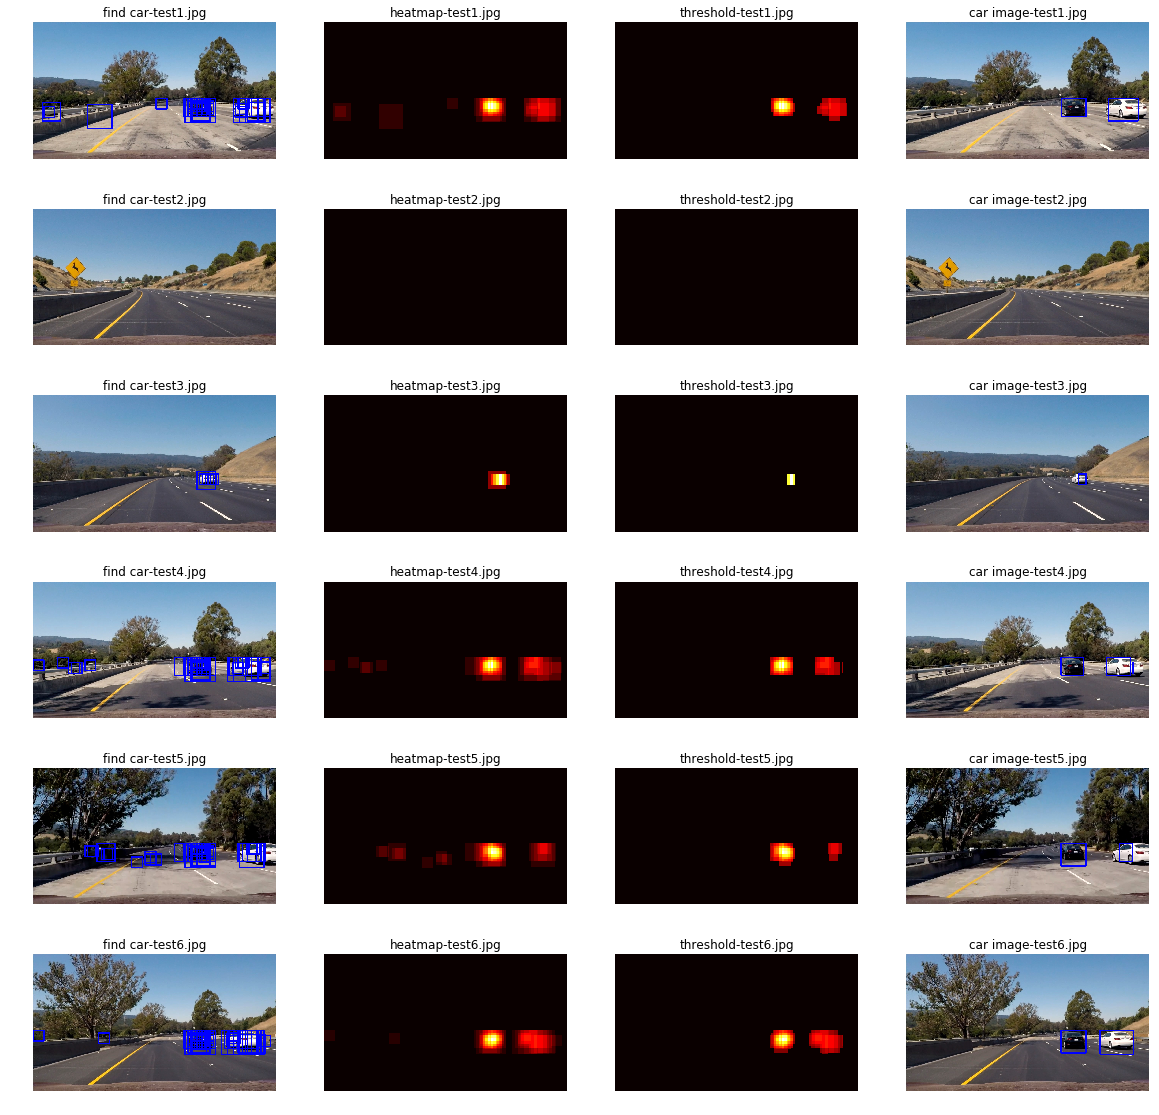

In [11]:
# Visualize Find Car function on test images, using scale 1, 1.5 and 2
images = glob.glob("test_images/*.jpg")

fig = plt.figure(figsize=(20,20))
for i, fname in enumerate(images):
    image = mpimg.imread(fname)
    draw_image = np.copy(image)
    hot_windows = []

    for scale in scales:
        car_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins)
        hot_windows.extend(car_windows)

    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, hot_windows)
    
    #fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(6,4,4*i+1)
    ax1.axis('off')
    ax1.set_title('find car-' + fname.split('\\')[-1])
    ax1.imshow(window_img)
    
    ax2 = fig.add_subplot(6,4,4*i+2)
    ax2.axis('off')
    ax2.set_title('heatmap-' + fname.split('\\')[-1])
    ax2.imshow(heatmap_img, cmap='hot')
    
    heatmap_threshold = apply_threshold(heatmap_img, 3)
    ax3 = fig.add_subplot(6,4,4*i+3)
    ax3.axis('off')
    ax3.set_title('threshold-' + fname.split('\\')[-1])
    ax3.imshow(heatmap_img, cmap='hot')
    
    labels = label(heatmap_threshold)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    ax4 = fig.add_subplot(6,4,4*i+4)
    ax4.axis('off')
    ax4.set_title('car image-' + fname.split('\\')[-1])
    ax4.imshow(draw_img)
    

    
plt.savefig('output_images/test_final.png')
plt.show()
    


## Vedio Pipeline

In [12]:
#Class holding hot window history from last 20 frames
class Window_History():
    def __init__(self):
        self.queue_len = 20
        self.win_history = []
    
    def add_hot_windows(self, hot_windows):
        if (len(self.win_history) == self.queue_len):
            self.win_history.pop(0)
        self.win_history.append(hot_windows)
    
    def get_all_windows(self):
        all_windows = []
        for windows in self.win_history:
            all_windows.extend(windows)
        
        return all_windows

# Processing pipeline
def image_pipeline(image):
    draw_image = np.copy(image)    
    image = image.astype(np.float32)/255
    hot_windows = []
    for scale in scales:
        car_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins)
        hot_windows.extend(car_windows)
    history.add_hot_windows(hot_windows)
    #print(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, history.get_all_windows())
    heatmap  = apply_threshold(heatmap,50)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    
    return window_image


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`test_video.mp4`

`project_video.mp4`


**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = image_pipeline(image)

    return result

In [15]:
history = Window_History()
test_output = 'test_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████████████████████████████████▏ | 38/39 [01:00<00:01,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 1s


Let's try the one with the project video first ...

In [18]:
history = Window_History()
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████▉| 1260/1261 [32:21<00:01,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 32min 22s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

Now for the one with the challenge video. This one's more tricky!

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


In [23]:
# Get some test image from project video
vidcap = cv2.VideoCapture('project_video.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,1000)      # just cue to 20 sec. position
success,image = vidcap.read()
if success:
    cv2.imwrite("frame01sec.jpg", image)     # save frame as JPEG file
    #cv2.imshow("20sec",image)
    cv2.waitKey
